In [1]:
# guillaumeflores

In [24]:
#Import Deep Learning libraries: Torch and Torchvision
#Import resnet50
#Import pre-trained CLIP model

import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, random_split
from torchvision.models import resnet50
from tqdm import tqdm
import clip

#Import data manipulation libraries

import numpy as np
import pandas as pd

#Import computer vision libraries

from PIL import Image
import matplotlib.pyplot as plt

import os

In [17]:

#Load the dataset into pandas dataframes
testData = pd.read_csv("./data/Human Action Recognition/Testing_set.csv")
trainData = pd.read_csv("./data/Human Action Recognition/Training_set.csv")

In [4]:
trainData

#print(trainData.iloc[0])

filename               label
0          Image_1.jpg             sitting
1          Image_2.jpg        using_laptop
2          Image_3.jpg             hugging
3          Image_4.jpg            sleeping
4          Image_5.jpg        using_laptop
...                ...                 ...
12595  Image_12596.jpg             sitting
12596  Image_12597.jpg            clapping
12597  Image_12598.jpg             sitting
12598  Image_12599.jpg             dancing
12599  Image_12600.jpg  listening_to_music

[12600 rows x 2 columns]

In [5]:
#Create Resnet Dataset/loader in order to use the dataset with torchvision
class ActionDataset(Dataset):
  def __init__(self, dataframe, dir, transform=None):
    self.dataframe = dataframe
    self.dir = dir
    self.transform = transform


    if self.dataframe.shape[1] == 2:
      self.labelMap =  {label: idx for idx, label in enumerate(self.dataframe['label'].unique())}
      #self.labelMap = dict(enumerate(self.dataframe['label'].unique()))

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):
    img_name = self.dataframe.iloc[index, 0]
    img = Image.open(f"{self.dir}/{img_name}").convert("RGB")

    if self.transform:
      img = self.transform(img)
    
    if self.dataframe.shape[1] == 2:
        img_label = self.dataframe.iloc[index,1]
        img_labelNum = self.labelMap[img_label]
        return img, torch.tensor(img_labelNum)
    else:
        return img, img_name


In [42]:
#Create CLIP Dataset/loader in order to use the dataset with torchvision
class ClipActionDataset(Dataset):
    def __init__(self, dataframe, dir, clip_processor=None):
        self.dataframe = dataframe
        self.dir = dir
        self.clip_processor = clip_processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_name = self.dataframe.iloc[index, 0]
        img = Image.open(f"{self.dir}/{img_name}").convert("RGB")

        if self.clip_processor:
            clip_image = self.clip_processor(img)
            return clip_image, img_name
        else:
            return img, img_name


In [25]:
#Create the transformer for image preprocessing
#This will ensure the images from the dataset match that of Resnet50

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


#Define and initialize the models
numClasses = len(trainData['label'].unique())
model = resnet50(weights='DEFAULT')
model.fc = nn.Linear(model.fc.in_features, numClasses)

# Freeze resnet model weights except for the final FC layer
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

#Define loss function and optimizer
lossFn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

#Load device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [57]:
#Load the data into torchvision dataset
train_data = ActionDataset(dataframe=trainData, dir="./data/Human Action Recognition/train", transform=transform)
test_data = ActionDataset(dataframe=testData, dir="./data/Human Action Recognition/test", transform=transform)
label_map = list(train_data.labelMap)

train_size = int(0.8*len(train_data))
val_size = len(train_data) - train_size

train_subset, val_subset = random_split(train_data, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, num_workers=0)

['sitting', 'using_laptop', 'hugging', 'sleeping', 'drinking', 'clapping', 'dancing', 'cycling', 'calling', 'laughing', 'eating', 'fighting', 'listening_to_music', 'running', 'texting']


In [9]:
def save_model(model, optimizer, epoch, filepath="./resnet50_har.pth"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, filepath)
    print(f"Model saved to {filepath}")

In [10]:
def train_model(model, train_loader, lossFn, optimizer, num_epochs=10):
    start_epoch = load_model(model,optimizer)
    
    #DEBUG
    print(f"Training starting from epoch {start_epoch + 1}...")
    
    for epoch in range(start_epoch, start_epoch + num_epochs):
        model.train()
        
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{start_epoch + num_epochs}", unit="batch") as prog_bar:
            for inputs, labels in train_loader:
                
                # DEBUG
                #print(f"Batch {prog_bar.n+1}: Loading data...")
                
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                loss = lossFn(outputs, labels)

                #Backward pass
                loss.backward()

                #Optimization step
                optimizer.step()
                
                # DEBUG
                #print(f"Batch {prog_bar.n+1}: Loss = {loss.item()}")

                # Track statistics
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_predictions += (preds == labels).sum().item()
                total_predictions += labels.size(0)
                
                # Update tqdm bar
                prog_bar.update(1)
                prog_bar.set_postfix({"Loss": loss.item(), "Accuracy": correct_predictions / total_predictions})


        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_predictions / total_predictions
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        
        save_model(model, optimizer, epoch)

In [11]:
def validate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        with tqdm(total=len(test_loader), desc="Validation", unit="batch") as prog_bar:
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_predictions += (preds == labels).sum().item()
                total_predictions += labels.size(0)
                
                prog_bar.update(1)
                prog_bar.set_postfix({
                    "Loss": running_loss / total_predictions if total_predictions > 0 else 0,
                    "Accuracy": correct_predictions / total_predictions if total_predictions > 0 else 0
                })

    val_loss = running_loss / len(test_loader.dataset)
    val_acc = correct_predictions / total_predictions
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")


In [12]:
def load_model(model, optimizer, filepath="./resnet50_har.pth"):
    if os.path.exists(filepath):
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Model loaded from {filepath}, starting at epoch {start_epoch + 1}")
        return start_epoch
    else:
        print(f"No saved model found at {filepath}. Starting from scratch.")
        return 0

In [13]:
def predict(model, test_loader, label_map):
    model.eval()
    predictions = []
    prob_dist = []
    filenames = []

    with torch.no_grad():
        for inputs, img_names in tqdm(test_loader, desc="Predicting"):
            inputs = inputs.to(device)
            outputs = model(inputs)

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1).cpu().numpy()

            # Map indices back to class names
            class_names = [list(label_map.keys())[list(label_map.values()).index(idx)] for idx in preds]
            prob_dist.extend(probs.cpu().numpy())
            predictions.extend(class_names)
            filenames.extend(img_names)

    # Create a DataFrame with predictions
    result_df = pd.DataFrame({'filename': filenames, 'predicted_label': predictions, 'probability_distribution': prob_dist})
    return result_df


In [46]:
def clip_predict(clip_model, clip_processor, test_loader, text_inputs, label_descriptions):
    clip_model.eval()
    results = []

    with torch.no_grad():
        for images, filenames in tqdm(test_loader, desc="CLIP Predictions"):
            images = images.to(device)
            image_features = clip_model.encode_image(images)
            text_features = clip_model.encode_text(text_inputs)


            # Normalize embeddings
            image_features = image_features / image_features.norm(dim=1, keepdim=True)
            text_features = text_features / text_features.norm(dim=1, keepdim=True)

            # Compute cosine similarity
            similarity = torch.matmul(image_features, text_features.T)  # Shape: [batch_size, num_labels]

            # Extract top predictions
            for i, filename in enumerate(filenames):
                probs = similarity[i].softmax(dim=0).cpu().numpy()
                sorted_indices = probs.argsort()[::-1]  # Descending order
                results.append({
                    "filename": filename,
                    "predicted_label": label_descriptions[sorted_indices[0]],
                    "probability_distribution": probs.tolist()
                })

    return pd.DataFrame(results)


In [13]:
train_model(model, train_loader, lossFn, optimizer, num_epochs=5)

No saved model found at ./resnet50_har.pth. Starting from scratch.
Training starting from epoch 1...


Epoch 1/5: 100%|███████████████████████████████████████| 394/394 [27:06<00:00,  4.13s/batch, Loss=1.08, Accuracy=0.607]


Epoch 1/5 - Loss: 1.3917, Accuracy: 0.6068
Model saved to ./resnet50_har.pth


Epoch 2/5: 100%|███████████████████████████████████████| 394/394 [25:10<00:00,  3.83s/batch, Loss=1.42, Accuracy=0.714]


Epoch 2/5 - Loss: 0.9424, Accuracy: 0.7144
Model saved to ./resnet50_har.pth


Epoch 3/5: 100%|██████████████████████████████████████| 394/394 [25:12<00:00,  3.84s/batch, Loss=0.546, Accuracy=0.747]


Epoch 3/5 - Loss: 0.8230, Accuracy: 0.7471
Model saved to ./resnet50_har.pth


Epoch 4/5: 100%|██████████████████████████████████████| 394/394 [25:02<00:00,  3.81s/batch, Loss=0.669, Accuracy=0.773]


Epoch 4/5 - Loss: 0.7468, Accuracy: 0.7733
Model saved to ./resnet50_har.pth


Epoch 5/5: 100%|██████████████████████████████████████| 394/394 [24:56<00:00,  3.80s/batch, Loss=0.589, Accuracy=0.789]

Epoch 5/5 - Loss: 0.6930, Accuracy: 0.7894
Model saved to ./resnet50_har.pth


In [26]:
validate_model(model, val_loader, lossFn)

Validation: 100%|███████████████████████████████████████| 79/79 [03:26<00:00,  2.61s/batch, Loss=0.572, Accuracy=0.836]

Validation Loss: 0.5718, Accuracy: 0.8361


In [14]:
result_df = predict(model, test_loader, train_data.labelMap)
result_df.to_csv("test_predictions.csv", index=False)
print(result_df.head())

Predicting: 100%|████████████████████████████████████████████████████████████████████| 169/169 [09:56<00:00,  3.53s/it]


      filename predicted_label  \
0  Image_1.jpg         sitting   
1  Image_2.jpg          eating   
2  Image_3.jpg          eating   
3  Image_4.jpg          eating   
4  Image_5.jpg         sitting   

                            probability_distribution  
0  [0.08289846, 0.06518527, 0.071257606, 0.068226...  
1  [0.06389775, 0.05822328, 0.07154539, 0.0656511...  
2  [0.082360536, 0.057054263, 0.05911259, 0.05264...  
3  [0.071108244, 0.07089036, 0.059038203, 0.07099...  
4  [0.08443682, 0.050011106, 0.06032956, 0.066049...  


In [38]:
#Prepare clip model
clip_model, clip_preprocessor = clip.load("ViT-B/32", device=device)

In [47]:
clip_model.eval()

label_desc = [ "A person " + label for label in trainData.label.unique()]

# Tokenize labels
text_inputs = clip.tokenize(label_desc).to(device)

clip_test_data = ClipActionDataset(
    dataframe=testData,
    dir="./data/Human Action Recognition/test",
    clip_processor=clip_preprocessor)

clip_test_loader = torch.utils.data.DataLoader(clip_test_data, batch_size=32, shuffle=False, num_workers=0)


In [48]:
clip_result_df = clip_predict(clip_model, clip_preprocessor, clip_test_loader, text_inputs, label_desc)
clip_result_df.to_csv("clip_test_predictions.csv", index=False)
print(clip_result_df.head())

CLIP Predictions: 100%|██████████████████████████████████████████████████████████████| 169/169 [10:16<00:00,  3.65s/it]


      filename    predicted_label  \
0  Image_1.jpg  A person sleeping   
1  Image_2.jpg    A person eating   
2  Image_3.jpg  A person fighting   
3  Image_4.jpg    A person eating   
4  Image_5.jpg   A person sitting   

                            probability_distribution  
0  [0.06724884361028671, 0.06707945466041565, 0.0...  
1  [0.06722420454025269, 0.06662337481975555, 0.0...  
2  [0.06683658808469772, 0.06739960610866547, 0.0...  
3  [0.06767450273036957, 0.06642787158489227, 0.0...  
4  [0.06856699287891388, 0.06792905926704407, 0.0...  


In [85]:
merged_df = pd.merge(result_df, clip_result_df, on="filename", suffixes=("_resnet", "_clip"))
combined_result = []

for _, row in merged_df.iterrows():
    probs_resnet = np.array(row["probability_distribution_resnet"])
    probs_clip = np.array(row["probability_distribution_clip"])
    combined_probs = (probs_resnet + probs_clip) / 2
    
    # Determine the new predicted label (argmax)
    max_index = np.argmax(combined_probs)
    
    # Store the filename, combined probabilities, and new label
    combined_result.append({
        "filename": row[0],
        "combined_probabilities": combined_probs.tolist(),
        "new_predicted_label": label_map[max_index]
    })

# Create a new DataFrame with the combined results
final_df = pd.DataFrame(combined_result)

# Save to CSV (optional)
final_df.to_csv("combined_predictions.csv", index=False)

# Preview the DataFrame
print(final_df.head())

      filename                             combined_probabilities  \
0  Image_1.jpg  [0.07507365196943283, 0.06613236293196678, 0.0...   
1  Image_2.jpg  [0.0655609779059887, 0.062423327937722206, 0.0...   
2  Image_3.jpg  [0.07459856197237968, 0.06222693435847759, 0.0...   
3  Image_4.jpg  [0.06939137354493141, 0.06865911558270454, 0.0...   
4  Image_5.jpg  [0.07650190591812134, 0.05897008255124092, 0.0...   

  new_predicted_label  
0             sitting  
1              eating  
2              eating  
3              eating  
4             sitting  


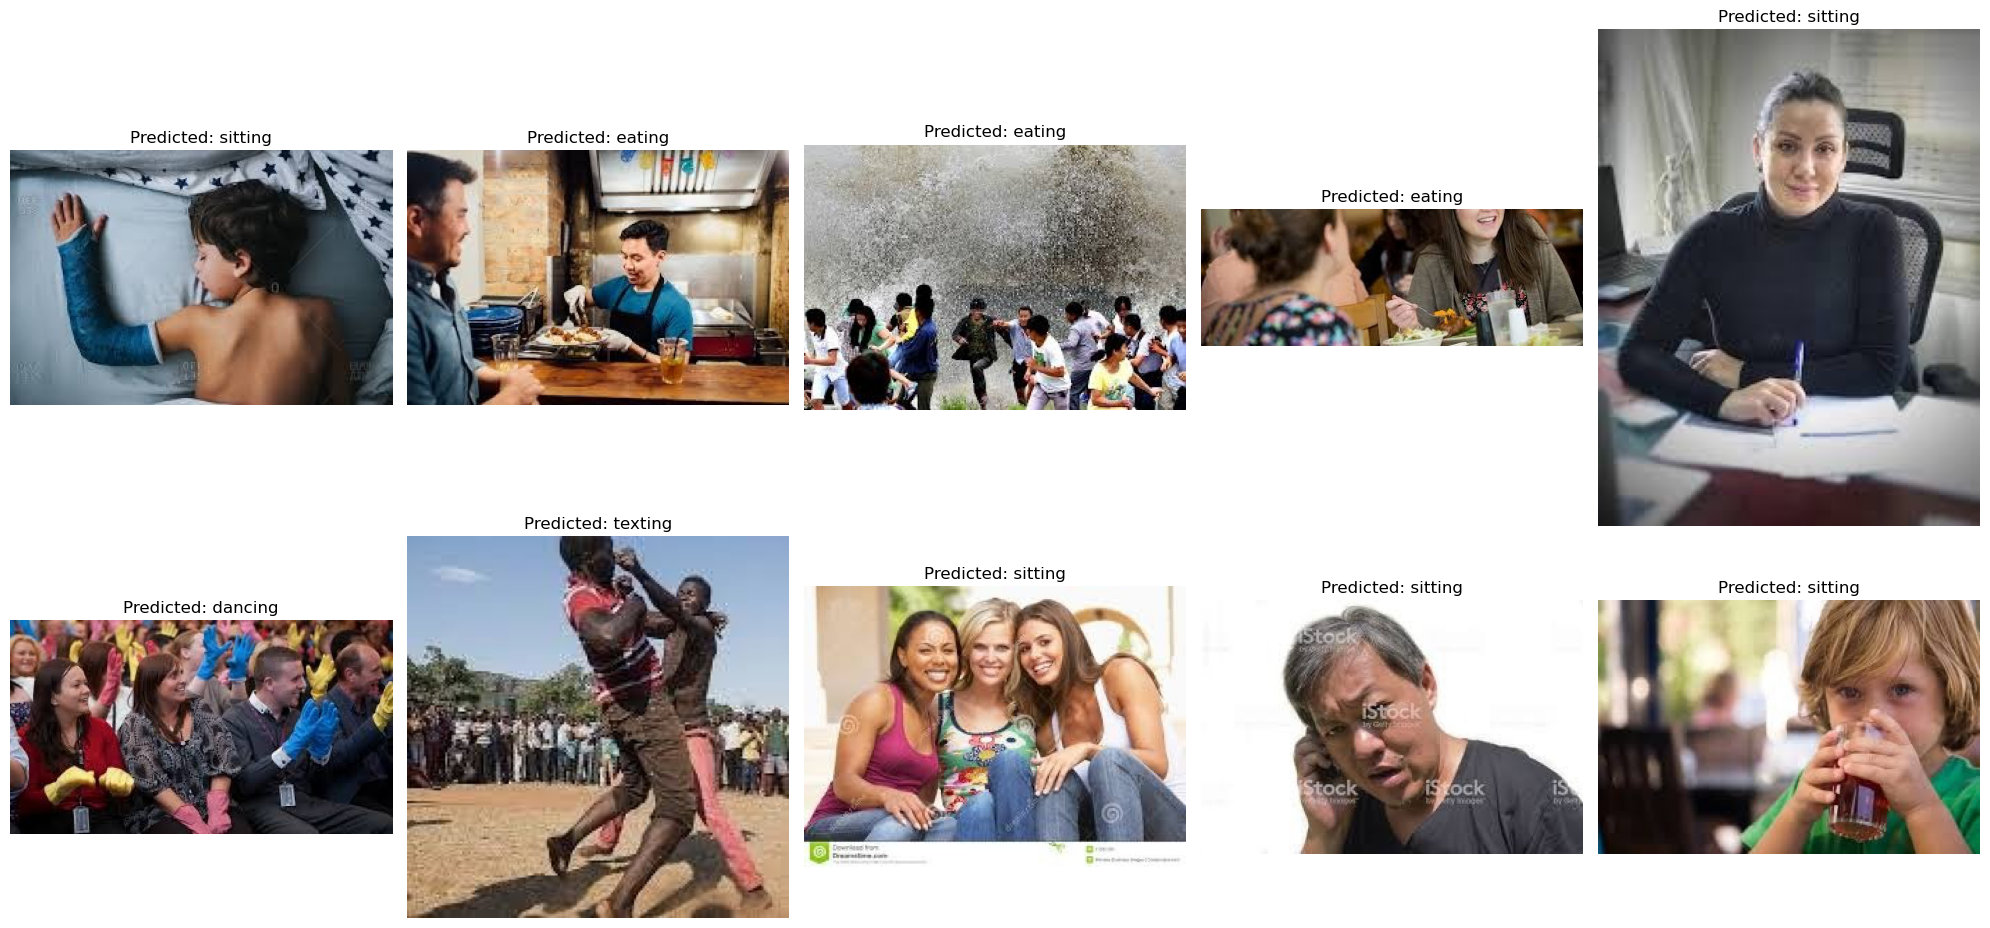

In [15]:
#Show prediction values given pretrained Resnet model (CNN)

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 rows, 5 columns
axes = axes.flatten()

for i, (_, row) in enumerate(result_df.head(10).iterrows()):
    img = Image.open(f"./data/Human Action Recognition/test/{row[0]}")
    axes[i].imshow(img)
    axes[i].set_title(f"Predicted: {row[1]}", fontsize=12)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

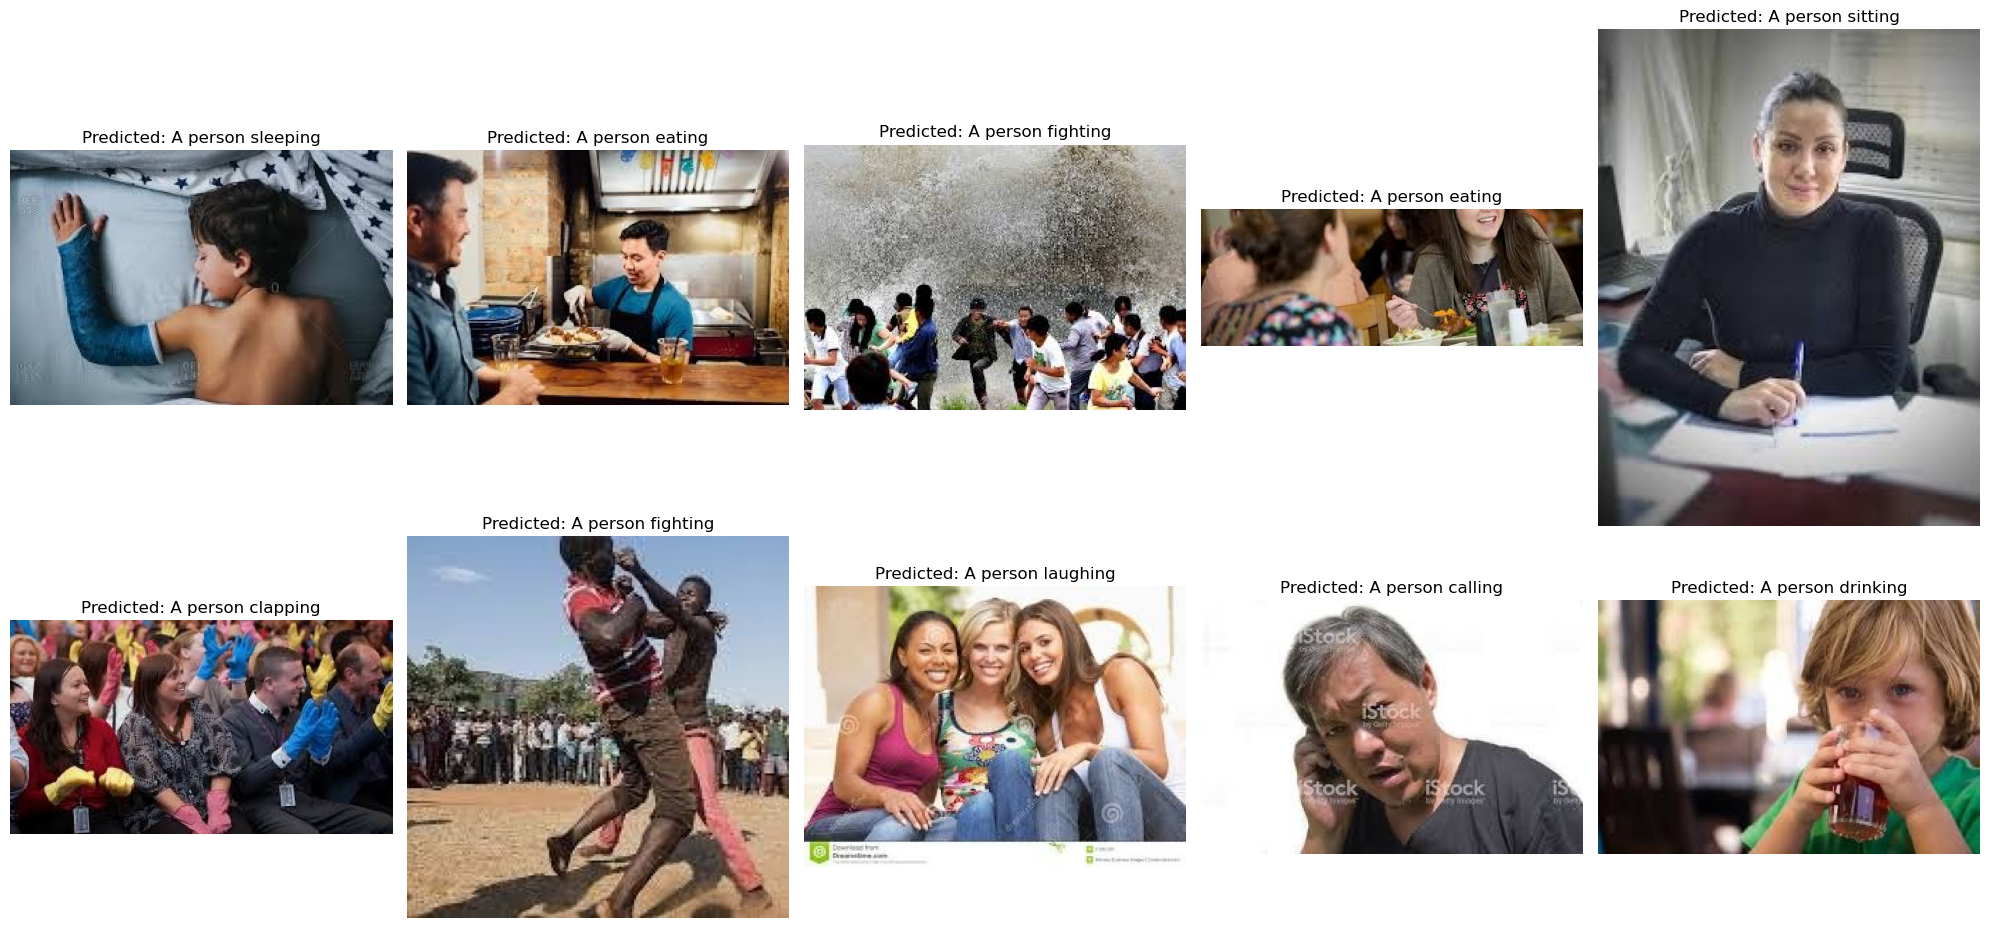

In [49]:
#Show prediction results given CLIP model

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 rows, 5 columns
axes = axes.flatten()

for i, (_, row) in enumerate(clip_result_df.head(10).iterrows()):
    img = Image.open(f"./data/Human Action Recognition/test/{row[0]}")
    axes[i].imshow(img)
    axes[i].set_title(f"Predicted: {row[1]}", fontsize=12)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

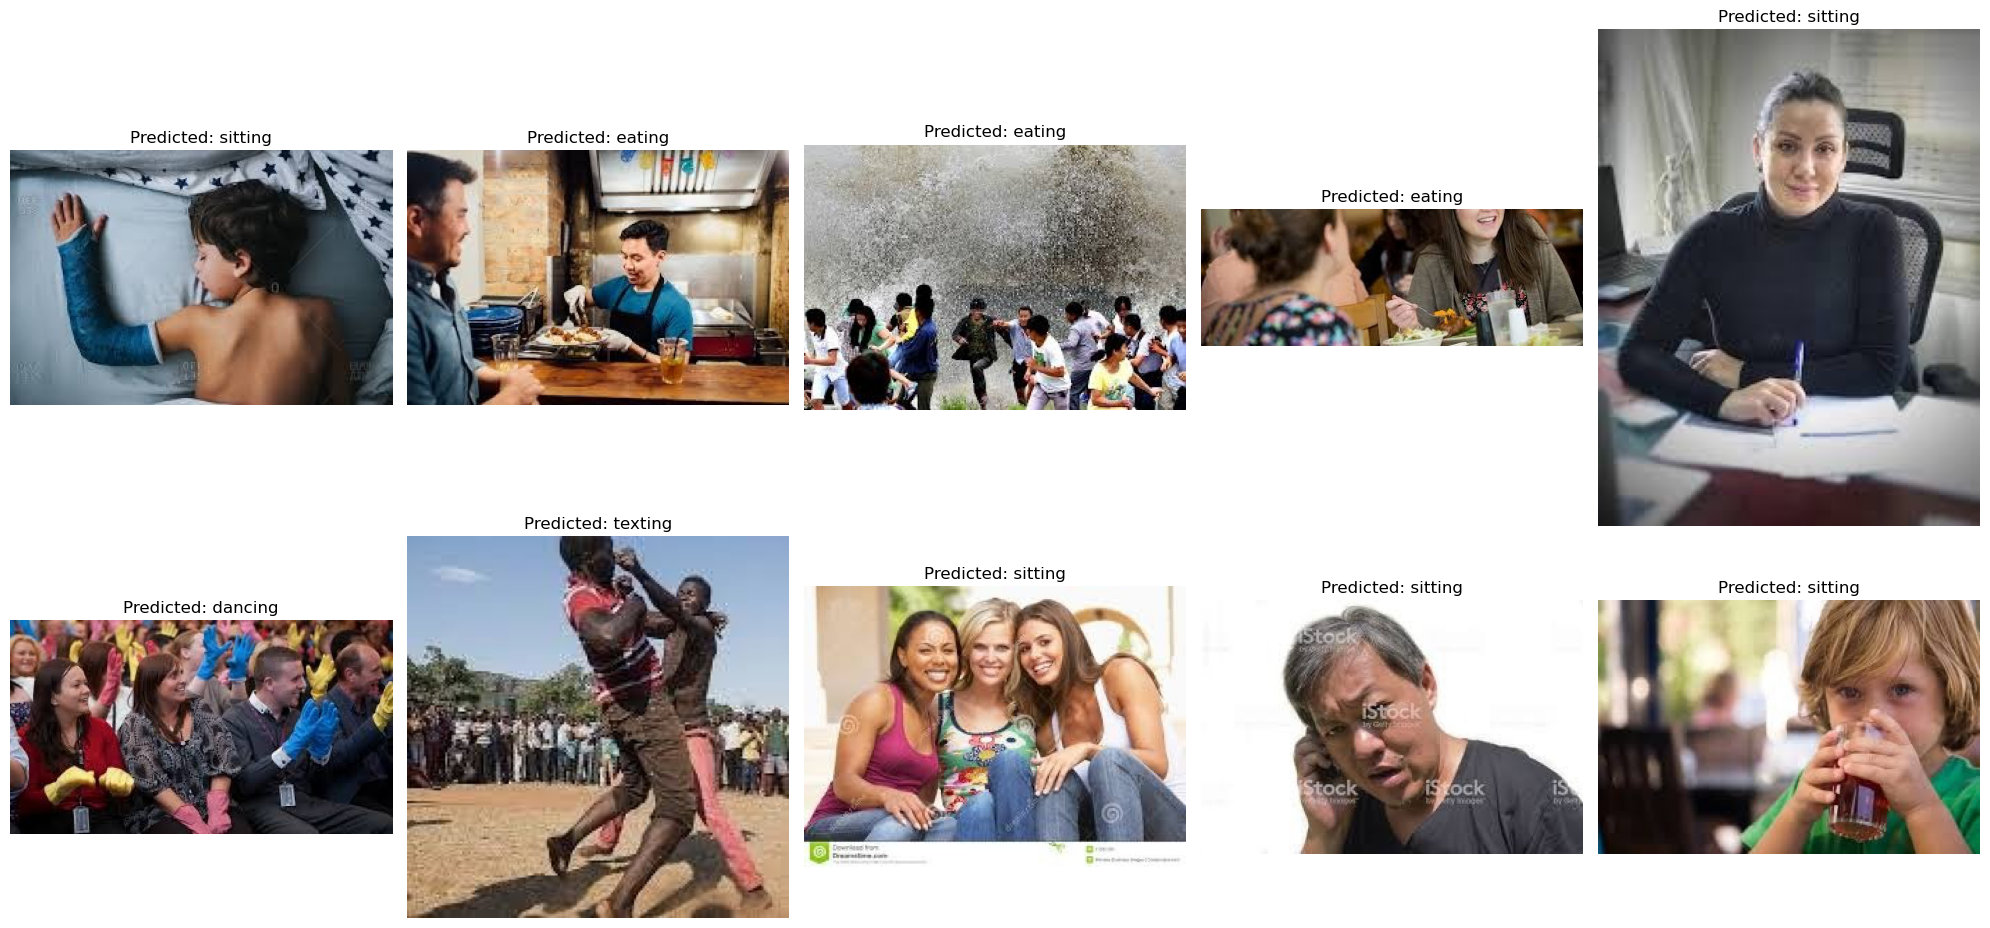

In [86]:
#Show prediction results when combining softmax results of both models
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 rows, 5 columns
axes = axes.flatten()

for i, (_, row) in enumerate(final_df.head(10).iterrows()):
    img = Image.open(f"./data/Human Action Recognition/test/{row[0]}")
    axes[i].imshow(img)
    axes[i].set_title(f"Predicted: {row[2]}", fontsize=12)
    axes[i].axis('off')

plt.tight_layout()
plt.show()